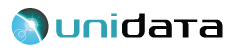
# Exploring MetPy
> As atmospheric scientists, you view, analyze, and synthesize a multitude of datasets every day. 
> These data and model output are collected by numerous entities and are stored in disparate locatons. 
> Luckily, we have access to the THREDDS catalog which nicely aggregates and organizes that data for us.
> Using MetPy, we can programmatically access, analyze, and display those data for our specific needs on demand. 

<a name="top"></a>

<div style="width:1000 px">

<h1>A Complete MetPy Workflow</h1>
<h3>MetPy: Creating Meteorological Python Workflows from Scratch</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Table of Contents
1. <a href="#siphon">Remote Data Access I: Working with Siphon</a>
1. <a href="#xarray">Working with xarray</a>
1. <a href="#ncss">Remote Data Access II: NetCDF Subset Service (NCSS)</a>
1. <a href="#cartopy">Coordinate Reference Systems</a>
1. <a href="#calc">Preview: Calculations</a>

## Table of Contents <a class="anchor" id="top"></a>

* [Objective](#objective)
* [Strategy](#strategy)
* [Step 0: Import required packages](#step0)
* [Step 1: Browse the THREDDS Data Server (TDS)](#step1)
* [Step 2: Satellite data](#step2)
    * [Step 2a: Obtain Satellite data](#step2a)
    * [Step 2b: Prepare Satellite data](#step2b)
    * [Step 2c: Visualize Satellite data](#step2c)
* [Step 3: Model output, equivalent potential temperature ($\theta_e$)](#step3)
    * [Step 3a: Obtain Model Output](#step3a)
    * [Step 3b: Prepare Model Output](#step3b)
    * [Step 3c: Visualize Model Output](#step3c)
* [Step 4: Surface observations](#step4)
    * [Step 4a: Obtain Surface observations](#step4a)
    * [Step 4b: Prepare Surface observations](#step4b)
    * [Step 4c: Visualize Surface observations](#step4c)
* [Step 5: Create multi-layer plot](#step5)

## Objective
Today, you will explore a few of the many uses of MetPy by creating a multi-layer plot like this one. Plots like these are ubiquitous in research, forecasting, and education. 

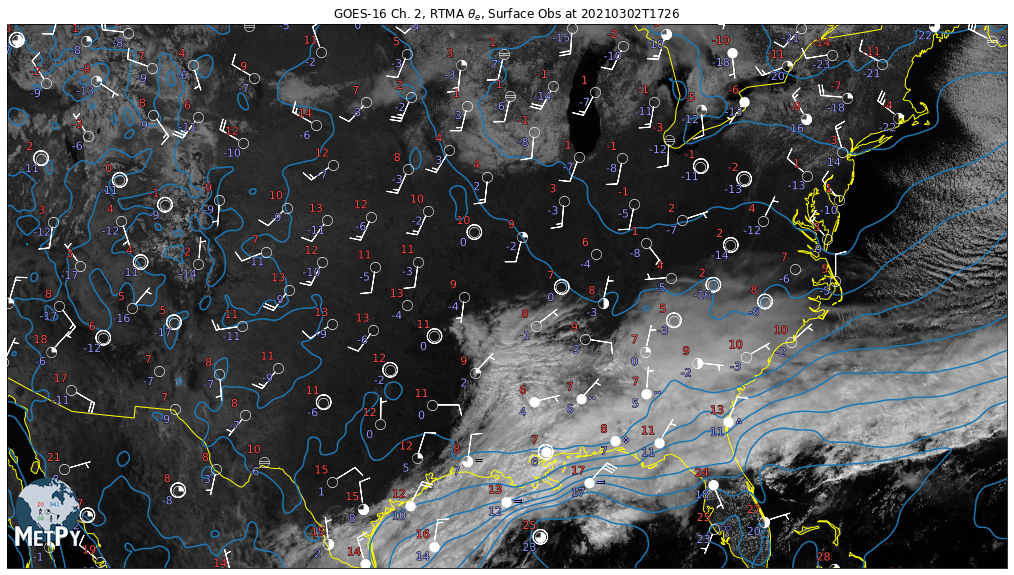

## Strategy <a class="anchor" id="strategy"></a>
Creating plots like this using MetPy follows this workflow:

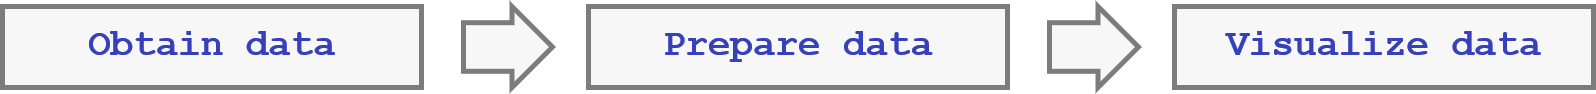

Since the plot you will be creating today includes three layers (satellite imagery, model output, and surface observations), you will repeat this process three times. With each iteration, you will discover nuances of each data product, what the product looks like on its own, and how to prepare it for a final production-quality plot. 

<div>
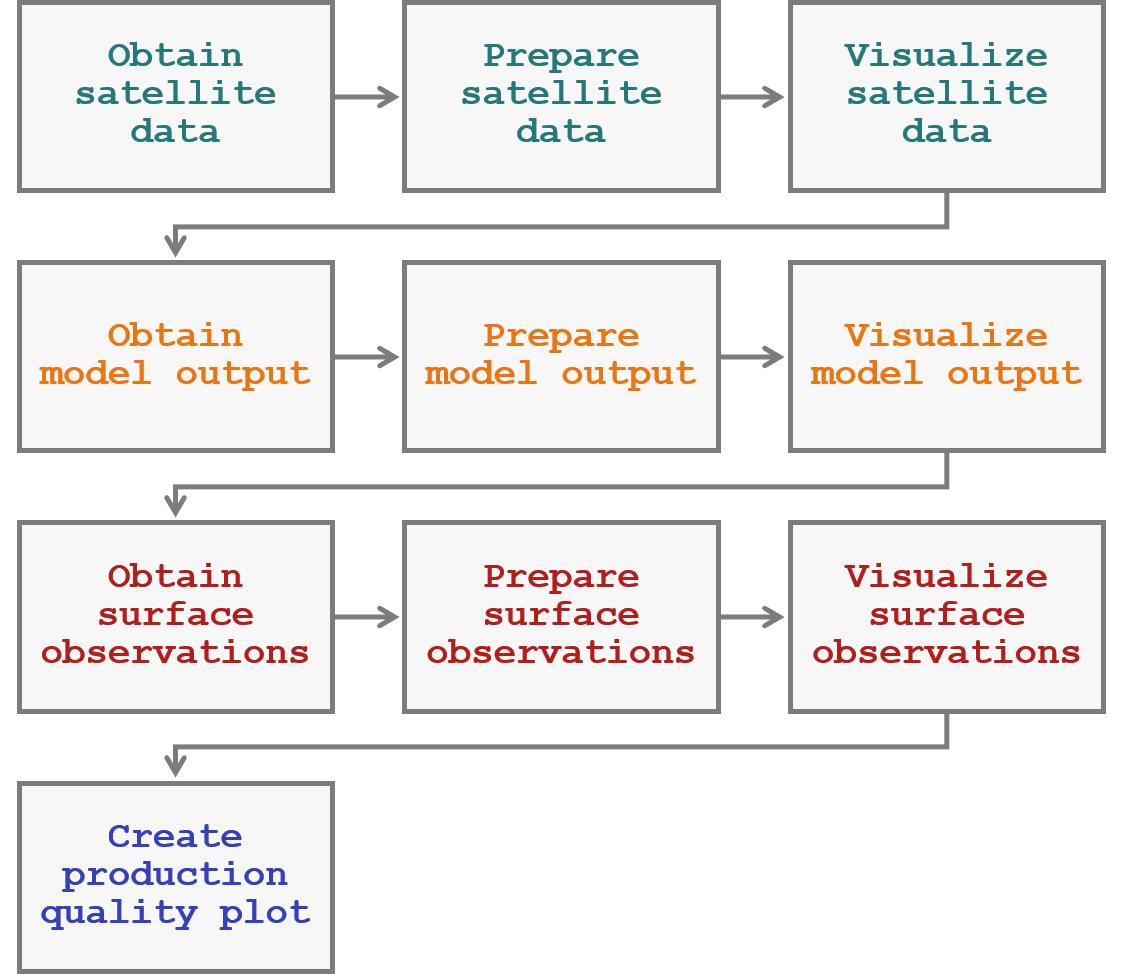
</div>

## Step 0: Import required packages <a class="anchor" id="step0"></a>
[Top](#top)  
But first, we need to import all our required packages. Today we're working with:
- datetime
- numpy
- io
- cartopy
- matplotlib
- metpy
- siphon

In [1]:
from datetime import datetime
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# We will use the standard "plt" abbreviation to access matplotlib
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke

import metpy.calc as mpcalc
import metpy.plots as mpplots

from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays

# Here is where we import the TDSCatalog class from siphon for obtaining our data 
from siphon.catalog import TDSCatalog

## Step 1: Browse the THREDDS Data Server (TDS) <a class="anchor" id="step1"></a>
[Top](#top)

The **THREDDS Data Server** provides us with coherent access to a large collection of real-time and archived datasets from a variety of environmental data sources at a number of distributed server sites. 
You can browse the TDS in your web browser using this link: <a href="https://thredds.ucar.edu/" target ="blank">https://thredds.ucar.edu/</a>


## Step 2: Satellite Data <a class="anchor" id="step2"></a>
[Top](#top)  


The first layer we will obtain is satellite imagery. To do this, we will create a THREDDS Data Server (TDS) catalog object, then extract a single image with its metadata, and visualize the result in a simple plot. For these tasks, we will leverage xarray to store the data in memory.  

<div>
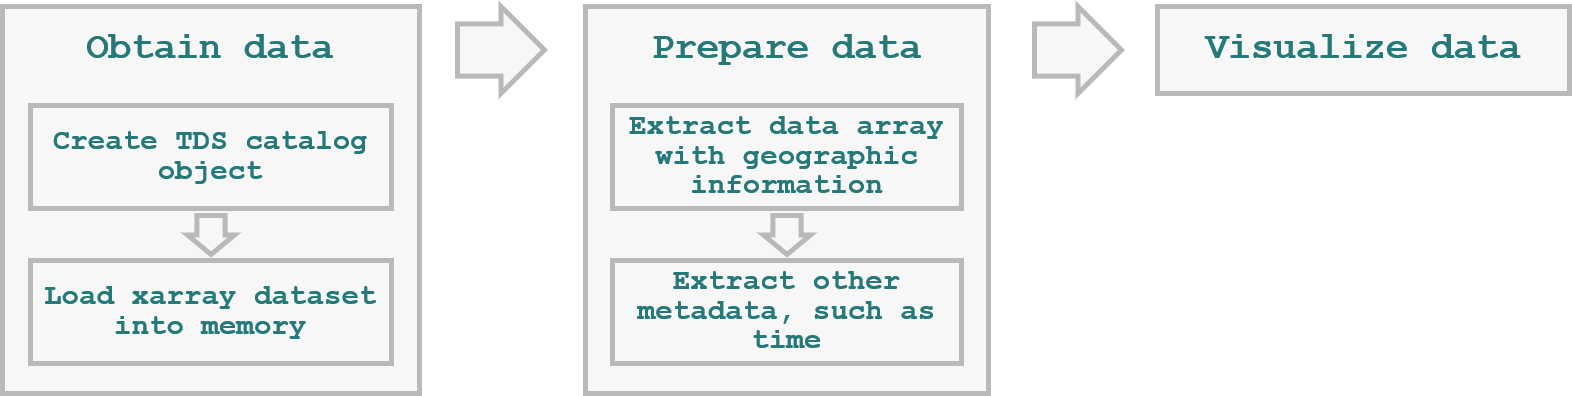
</div>

### Step 2a: Obtain Satellite Data <a class="anchor" id="step2a"></a>
[Top](#top)

We will use siphon's TDSCatalog object to create a catalog of satellite data from the TDS that match our criteria (the most recent GOES East, cloud and moisture imagery, CONUS extent, channel 2 data).  

Then we use siphon's remote_access method to read in the most recent satellite image from the catalog into an xarray Dataset. 


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    Notice the URL in the TDSCatalog input ends with .xml rather than .html. While your web browser uses html to show you the data in a human-friendly webpage, siphon requires an xml document to create the TDSCatalog object.
</div>


In [2]:
# Create TDS catalog object
satcat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml"
)

# satcat includes many images as a part of the catalog
# choose the first (most recent) image in the catalog, index = 0
satdata = satcat.datasets[0].remote_access(use_xarray=True)

### Step 2b: Prepare Satellite Data <a class="anchor" id="step2b"></a>
[Top](#top)

Next, we'll pull the satellite image (as an xarray DataArray) from satdata (an xarray Dataset) using the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.xarray.html#metpy.xarray.MetPyDatasetAccessor.parse_cf" target="blank">metpy `parse_cf` method </a>with the variable name *"Sectorized_CMI"* as input. 

Using the datetime package, we'll extract the *"start_date_time"* attribute from satdata. GOES East stores data in julian days (year, day of the year, hours, minutes, seconds). 

In [3]:
# extract the DataArray 
cmi = satdata.metpy.parse_cf("Sectorized_CMI")

# extract the date and time
dt = datetime.strptime(satdata.attrs["start_date_time"], "%Y%j%H%M%S")

### Step 2c: Visualize Satellite Data <a class="anchor" id="step2c"></a>
[Top](#top)

Now that we have the data ready, it's time to **plot**. Incrementally plotting data is considered a best practice for understanding the data you are working with and determining if you are on your way to creating your intended product.
<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Plot CMI</p>
    To plot this image, we will use <b>matplotlib</b> to display our data. Let's first make sure we have the information we need: <br> 
<ul>
    <li>What is the name of the dataarray variable we need to plot?</li>
    <li>What is the matplotlib function to use?</li>
    <li>What is the correct syntax for using the function?</li>
</ul>
</div>




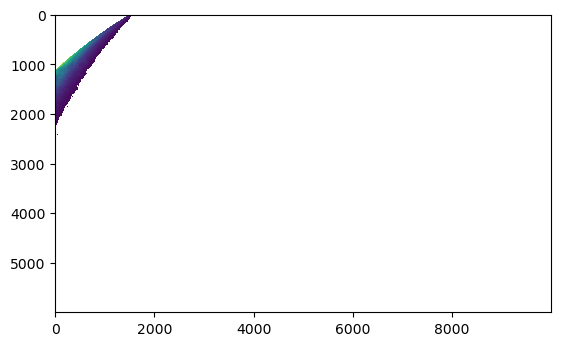

In [4]:
# ACTIVITY: Plot CMI 
# Create your plot code below



## INSTRUCTOR'S ANSWER KEY ## 
plt.imshow(cmi)

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Challenge: Plot CMI</p>
    Using the matplotlib documentation as a reference, change the color map of your above plot to grayscale <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="blank">https://matplotlib.org/stable/tutorials/colors/colormaps.html</a>
</div>

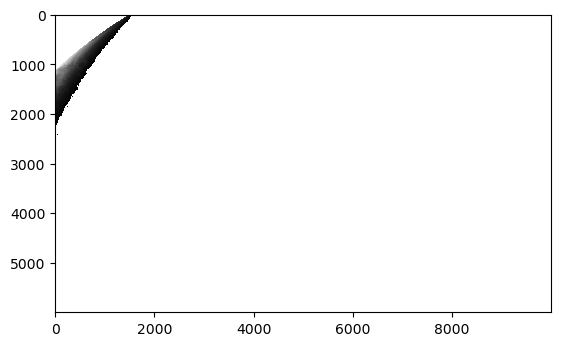

In [5]:
# CHALLENGE: Plot CMI




## INSTRUCTOR'S ANSWER KEY ## 
plt.imshow(cmi, cmap="Greys_r")

## Step 3: Model output, equivalent potential temperature ($\theta_e$) <a class="anchor" id="step3"></a>
[Top](#top)


Now we grab data from the Real-time Meso-analysis (RTMA), which gives us a gridded estimate of the realtime conditions. Our goal is to use MetPy to calculate <a href="https://glossary.ametsoc.org/wiki/Equivalent_potential_temperature" target="blank">equivalent potential temperature ($\theta_e$)</a>, using the fields we have available in the RTMA. 

This time we will also add some additional detail to our intermediate plot. To provide geographic reference, we will plot with a geographic projection and add coastlines. 

<div>
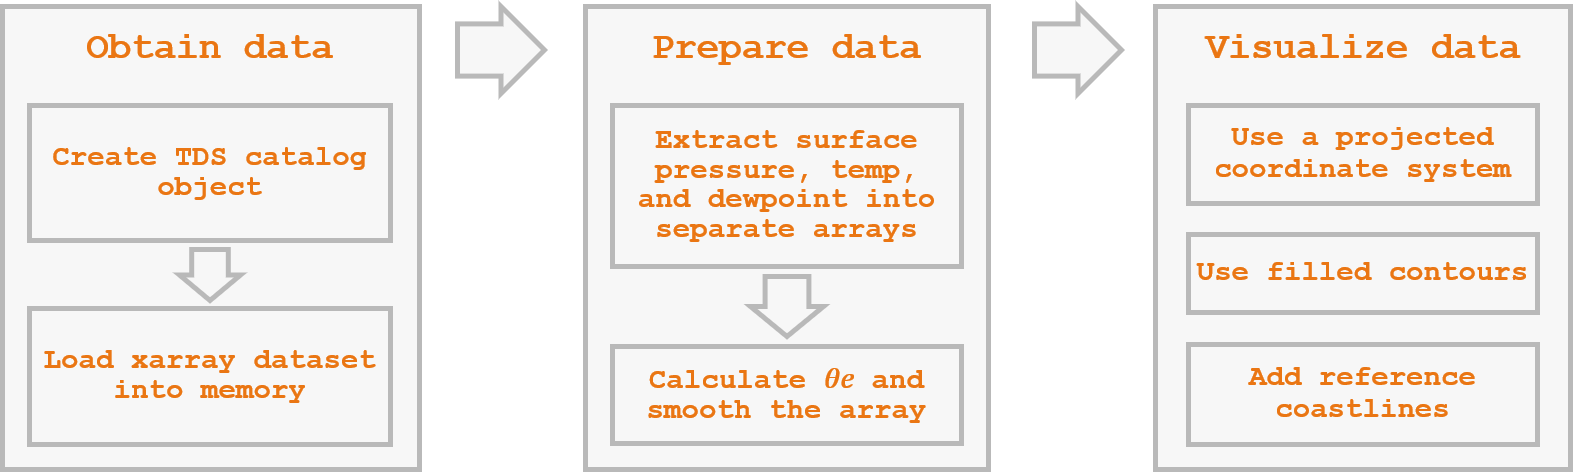
</div>

### Step 3a: Obtain Model Output <a class="anchor" id="step3a"></a>
[Top](#top)

Using similar methods as above, we 
1. Create a TDSCatalog object of the data we specify (RTMA output over the CONUS extent).
2. Pull the Full Collection Dataset into an in-memory xarray Dataset.
3. Parse dataset for coordinate system metadata according to CF conventions.

In [6]:
# Again using Siphon, get the full collection of RTMA 
# data opened using xarray.
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

### Step 3b: Prepare Model Output <a class="anchor" id="step3b"></a>
[Top](#top)

Before we calculate any derived variables, we need to look up the required input variables. Looking at the metpy.calc documentation for <a href ="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.equivalent_potential_temperature.html#metpy.calc.equivalent_potential_temperature" target="blank">equivalent potential temperature</a>, we can see that this function requires three variables: surface pressure, temperature, and dewpoint. Each of these variables are contained in our rtma_data Dataset, but we need to know what variable name each are stored under. 


<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Find RTMA Variable Names</p>
    <code>rtma_data</code> is an xarray Dataset containing several variables. Use the cell below to programmatically display the list of all variables in the Dataset, then find the names of the <b>surface pressure</b>, <b>temperature</b>, and <b>dewpoint</b> variables. 
</div>


In [7]:
# ACTIVITY: Find RTMA Variable Names




## INSTRUCTOR'S ANSWER KEY ##
# Recall from prework
# Have learner share in chat window
# NOTE: without using print, errors may come up accessing one specific variable before the variable list is displayed
print(rtma_data)

<xarray.Dataset>
Dimensions:                                                              (
                                                                          validtime3Offset: 1,
                                                                          : 2,
                                                                          reftime1: 721,
                                                                          validtime4Offset: 1,
                                                                          x: 2145,
                                                                          ...
                                                                          timeOffset: 1,
                                                                          reftime5: 720,
                                                                          validtime1Offset: 1,
                                                                          reftime3: 720,
                           

Surface pressure is stored in the *"Pressure_Analysis_surface"* variable name. We'll use this to select the DataArray within that variable at the time closest to that of the satellite image (at time = `dt`). Here we use the <a href="http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html" target="blank">xarray `sel` method</a>. 

Notice the use of the `squeeze()` method. This helps eliminate any stray dimensions for the vertical since we want a 2D array as output (some values are at a particular height, like 2 m, rather than the surface).

In [8]:
# Store the surface pressure DataArray to variable `pres`
pres = rtma_data.Pressure_Analysis_surface.sel(reftime=dt, method='nearest').squeeze()

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Create Temperature and Dewpoint DataArrays</p>
    Using the information from the previous activity and following the demonstration in the previous cell, create <code>temp</code> and <code>dewp</code> variables that represent the surface temperature and dewpoint, respectively. 
</div>

In [9]:
# ACTIVITY: Create Temperature and Dewpoint DataArrays

# temp = 
# dewp = 


## INSTRUCTOR'S ANSWER KEY ##
temp = rtma_data.Temperature_Analysis_height_above_ground.sel(reftime1=dt, method='nearest').squeeze()
dewp = rtma_data.Dewpoint_temperature_Analysis_height_above_ground.sel(reftime1=dt, method='nearest').squeeze()


<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Calculate theta_e</p>
    Now, calculate equivalent potential temperature using the  <a href ="https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html" target="blank">metpy.calc documentation</a>. Create a variable called <code>theta_e</code> to represent the equivalent potential temperature field.
</div>

In [10]:
# ACTIVITY: Calculate theta_e


# theta_e = 



## INSTRUCTOR'S ANSWER KEY ##
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Challenge: Calculate another variable</p>
    Locate another derived variable in the metpy.calc documentation that takes in any combination of surface pressure, temperature, or dewpoint, then calculate it as a new variable. Plot it using any plotting tool to visualize the output.
</div>

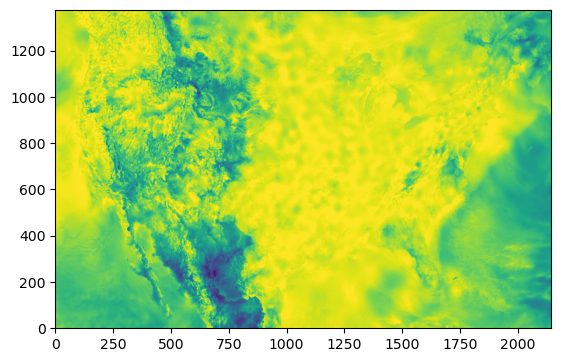

In [11]:
# CHALLENGE: Calculate another variable



## INSTRUCTOR'S ANSWER KEY ##
# one of many possibilities
rh = mpcalc.relative_humidity_from_dewpoint(temp, dewp)
plt.imshow(rh, origin="lower")

Now, smooth the theta_e array using a gaussian filter. This will improve the readability of the final plot.

In [12]:
# smooth the theta_e array
theta_e = mpcalc.smooth_gaussian(theta_e, n=50)

We can use MetPy shortcuts to create a cartopy <a href="https://scitools.org.uk/cartopy/docs/latest/crs/index.html#cartopy.crs.CRS">cartographic reference system</a> for our data. RTMA uses a Lambert Conformal projection, which we will use in our final multi-layer plot. This is our final data preparation step for the `theta_e` DataArray. 

In [13]:
# Create the crs object for the theta_e array
rtma_crs = theta_e.metpy.cartopy_crs

### Step 3c: Visualize Model Output <a class="anchor" id="step3c"></a>
[Top](#top)


The data are now prepared for plotting. Let's now use a different plotting technique, **filled contours**, for visualizing the $\theta_e$ field. Let's also reproject the DataArray onto a **Robinson** projection, and add cartopy's built-in `coastlines` class for geographic context.  

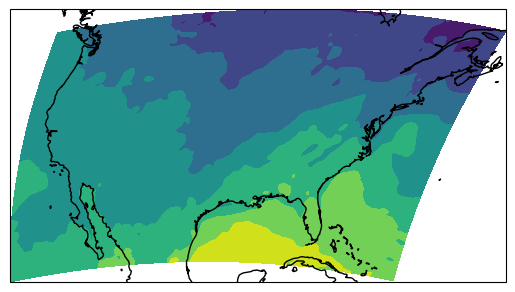

In [14]:
# Create figure, axes, then use contourf to create filled contours of the theta_e field
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.Robinson())
ax.contourf(theta_e['x'], theta_e['y'], theta_e, transform=rtma_crs)
ax.coastlines()

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Tip</p>
    If you are working with xarray DataArrays parsed via <code>metpy.parse_cf</code>, and you aren't sure what your horizontal variables (e.g. x, or lon, or latitude) are named, or you just want a shortcut, you can access these quickly with <code>xarray.metpy.x</code> and <code>xarray.metpy.y</code>.<br><br>For example, these two lines of code are equivalent for DataArrays parsed with <code>metpy.parse.cf</code>:<br><br>
    <code>ax.contourf(theta_e['x'], theta_e['y'], theta_e, transform=rtma_crs)</code><br>
    <code>ax.contourf(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform=rtma_crs)</code>
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Contour plots</p>
    You will complete this activity as a part of a team. You will be assigned a group number and you will document your output on your group's designated slide in the provided presentation.<br><br>
    To more closely match the final multi-layered plot, you will now do the following:<br>
    <ol>
    <li>Plot <code>theta_e</code> using the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html" target="blank">matplotlib <code>contour()</code> plot type</a>.</li>
    <li>Use the LambertConformal projection in your axes, the same projection the RTMA dataset uses.</li>
    <li>Add coastlines.</li>
    <li>Make the contours a single color (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html" target="blank">see examples here</a>).</li>
    <li>Add a descriptive title to your plot.</li>
    <li>Copy your plot into your group's designated slide at the link provided.</li> 
        <dl>
            <dd>To copy an image from a notebook: Shift + right click on the image, then select Copy image</dd>
        </dl>
    </ol>
    After your group has created the <code>theta_e</code> plot, you are free to create more contour plots of other RTMA variables you have created in this notebook. Choose any colors, but label your plots with titles that describe the variable(s) plotted. 

</div>


In [15]:
# ACTIVITY: Contour plots




## INSTRUCTOR'S ANSWER KEY ##
#ax = plt.axes(projection=rtma_crs)
#ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform=rtma_crs, colors='blue')
#ax.coastlines()

## Step 4: Surface Observations <a class="anchor" id="step4"></a>
[Top](#top)    

Finally, we will add <a href ="https://www.wpc.ncep.noaa.gov/html/stationplot.shtml" target="blank">station plots</a> to our map. Creating a map of station plots is a bit different from our previous two map layers. We're no longer looking at 2D arrays of data, and instead we're looking at a collection of points containing several observations. Despite those differences, though, the same general workflow applies: obtain, prepare, and plot the data. However, the details of each will differ greatly from the satellite and $\theta_e$ plots.  

<div>
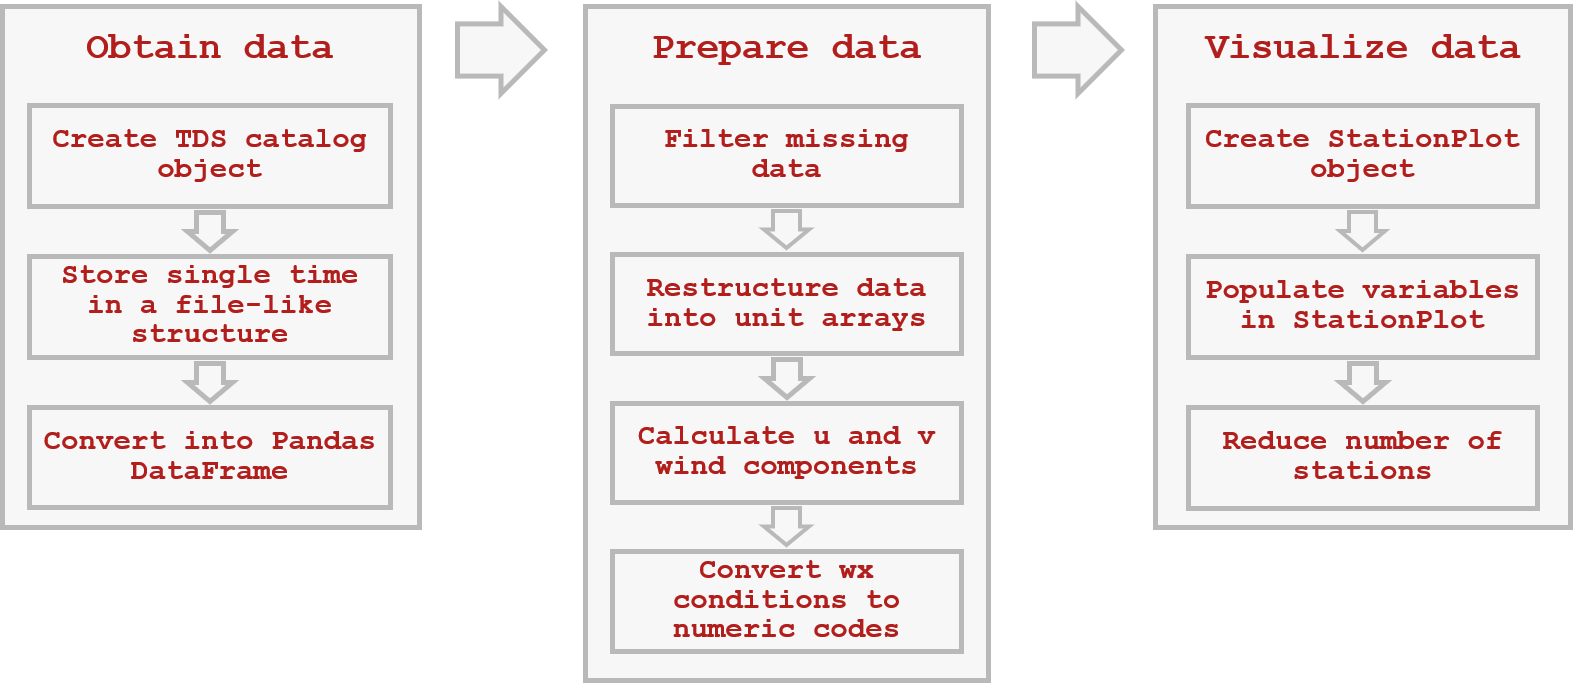
</div>

### Step 4a: Obtain Surface Observations <a class="anchor" id="step4a"></a>
[Top](#top)  


The METAR data we'll use is on a different THREDDS Data Server, notice the change in URL. Then, we'll grab the file from the time closest to that of the satellite image. 

In [16]:
# Create TDSCatalog of METAR data
metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

# Open the metar file that contains data
# closest to the satellite image time, dt
metar_text = metar_cat.datasets.filter_time_nearest(dt).remote_open(mode='t')

### Step 4b: Prepare Surface Observations <a class="anchor" id="step4b"></a>
[Top](#top)

`metar_text` now holds an object containing our METAR data in ascii text. Now we will prepare the data for plotting by converting it into a pandas DataFrame object using `parse_metar_file()`. A pandas DataFrame is similar to a spreadsheet in that the data are stored into rows and columns. 

Example:
<div>
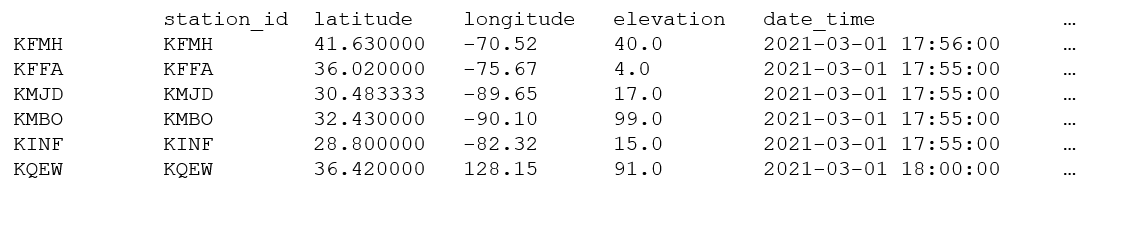
</div>

This structure allows us to more easily apply some quality control. Using Pandas, we will remove stations that do not have a useful lat/lon value (empty or null), as well as set missing current weather observations to an empty string.

In [17]:
# parse_metar_file() outputs a pandas DataFrame
sfc_data = parse_metar_file(metar_text, year=dt.year, month=dt.month)

# Save the units for all columns to a new variable
sfc_units = sfc_data.units

Now we convert the Pandas DataFrame object into a dictionary object, where each column is now a unique key. This structure is what MetPy requires for creating the final station plot.
<div>
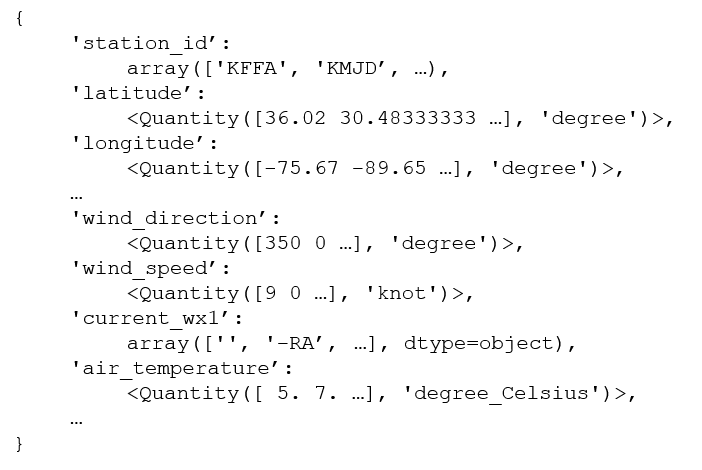
</div>


In [18]:
# Create final data structure
sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

The next preparation step is to prepare the current weather conditions. METARs use <a href="https://www.weather.gov/media/wrh/mesowest/metar_decode_key.pdf" target="blank">text abbreviations</a> to denote the current weather conditions, but MetPy requires that these codes be converted to the <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html#metpy.plots.StationPlot.plot_symbol" target="blank">World Meteorological Organization (WMO) numerical code</a> for plotting. 

For example:
<div>
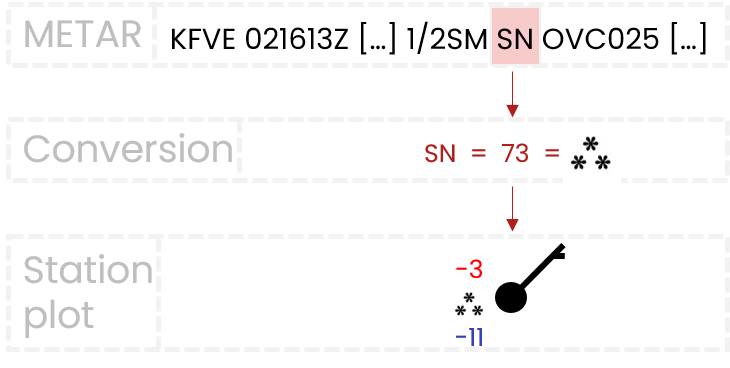
</div>

MetPy does this for you behind-the-scenes by converting the reported weather (`'current_wx1'`, etc.) to a symbol via this corresponding WMO code during the text parsing process.

### Step 4c: Visualize Surface Observations <a class="anchor" id="step4c"></a>
[Top](#top)

Now that we have completed all of our data preparation, we can start building the station plot. To do this, we need <a href="https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html" target="blank">MetPy's `StationPlot` class</a>. The `StationPlot` class acts as a template that we fill in with the surface observations stored in the `sfc_data` variable.


The station plot is broken up into regions surrounding a center point. The variables we'll be plotting are:
1. air temperature (red, north west `NW` region)
2. dew point temperature (blue, south west `SW` region)
3. cloud coverage (white, center `C` region)
4. current weather symbol/wx code (blue, east `E` region)
5. wind speed and direction (wind barb). 

Example: 
<div>
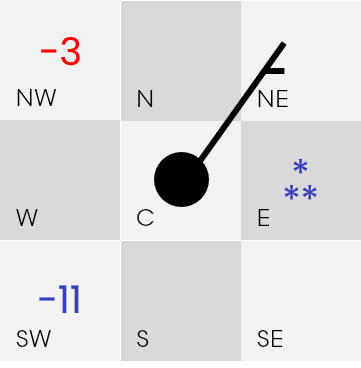
</div>

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    We are making a few changes from the standard station plot for accessibility and readability. Traditionally, the dewpoint value is displayed in green. However, we are making a modification to make our final plot more accessible to colorblindness. We are also moving the wx code to the east (as oppposed to west) to increase readability.
</div>


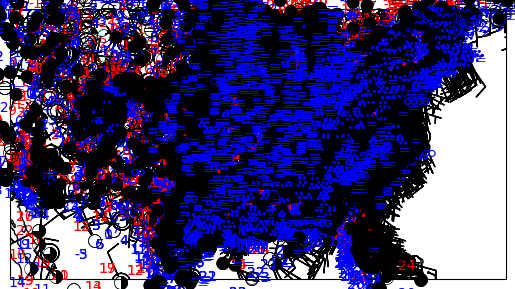

In [19]:
# Start by creating the matplotlib axes
fig = plt.figure()
ax = fig.add_subplot(projection=rtma_crs)

# Create the station plot object, stn,
# from the StationPlot class, using the
# PlateCarree projection
stn = mpplots.StationPlot(ax, sfc_data['longitude'].m, sfc_data['latitude'].m, transform=ccrs.PlateCarree())

# Populate the temperature and dewpoint
stn.plot_parameter('NW', sfc_data['air_temperature'], color='red')
stn.plot_parameter('SW', sfc_data['dew_point_temperature'], color='blue')

# Populate the center circle cloud coverage and weather code
stn.plot_symbol('C', sfc_data['cloud_coverage'], mpplots.sky_cover)
stn.plot_symbol('E', sfc_data['current_wx1_symbol'], mpplots.current_weather, color='blue')

# Populate the wind bard
stn.plot_barb(sfc_data['eastward_wind'], sfc_data['northward_wind'])

# Add coastlines and set extent to the Southeast US
ax.coastlines()
ax.set_extent((-113, -70, 25, 45))

Oh. Oh no. 

Because there are so many surface observations available, we ended up with an illegible plot. Let's now select only a subset of the stations to plot by creating a mask (filter) over our surface observations. The output should limit the number of stations to one station every 175 km.

In [20]:
# Create an array of station locations
locs = rtma_crs.transform_points(ccrs.PlateCarree(), sfc_data['longitude'].m, sfc_data['latitude'].m)

# Create the 1:175 km plot mask
plot_mask = mpcalc.reduce_point_density(locs[..., :2], 175000, priority=sfc_data['current_wx1_symbol'])

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Apply Plot mask</p>
    Populate all variables as previous, but apply the <code>plot_mask</code> this time. The temperature field is completed for you. Continue with dewpoint, cloud coverage, wx_code, and the wind barb.
</div>

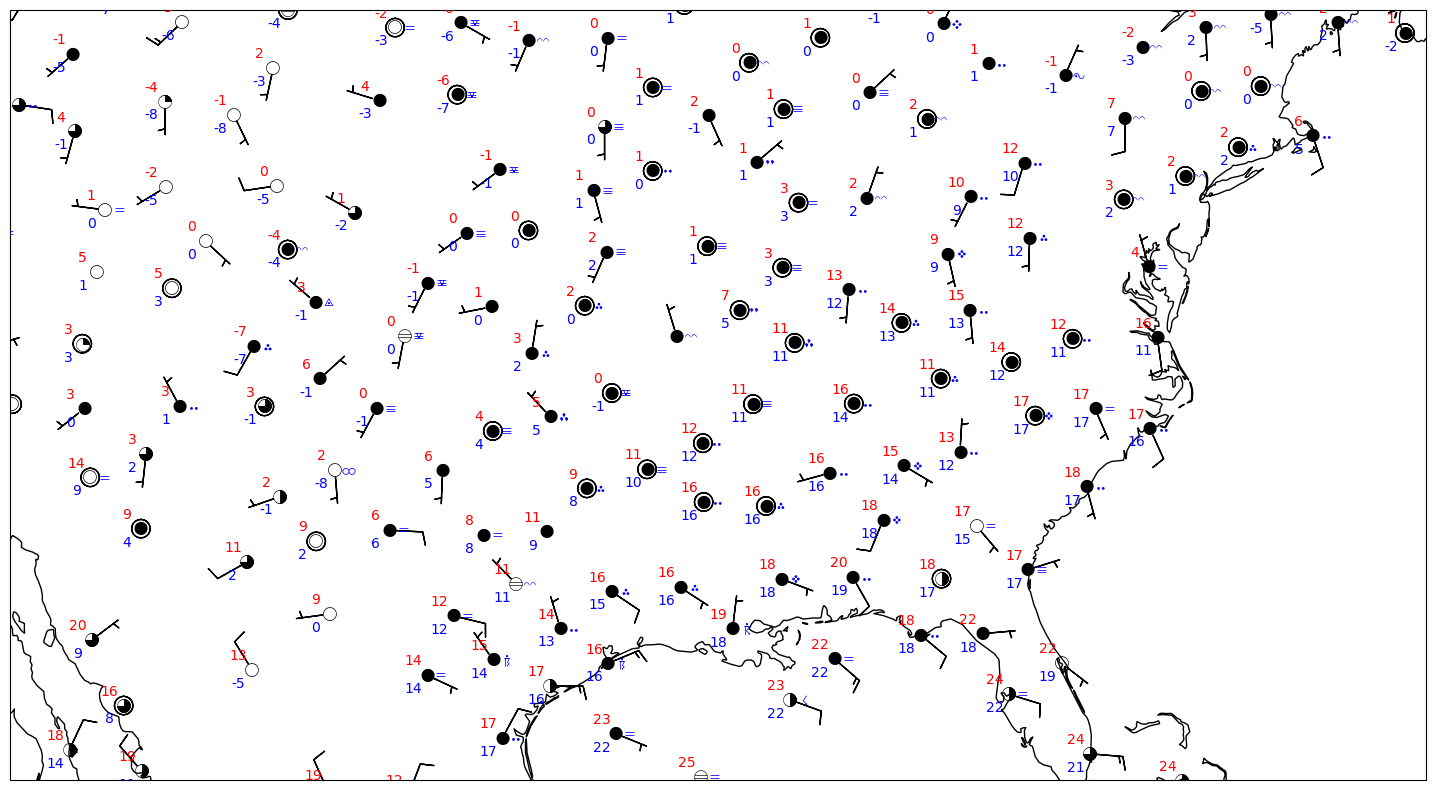

In [21]:
# Increase the size of the plot on the screen
fig = plt.figure(figsize=(20, 10))

# Create matplotlib axes in the Plate Carree projection
ax = fig.add_subplot(projection=rtma_crs)

# Create the StationPlot class with the plot_mask applied 
# (append [plot_mask] to the end of each variable)
stn = mpplots.StationPlot(ax, sfc_data['longitude'][plot_mask].m, sfc_data['latitude'][plot_mask].m, transform=ccrs.PlateCarree(), clip_on=True)

# Populate all variables as previous, but apply the plot_mask
stn.plot_parameter('NW', sfc_data['air_temperature'][plot_mask], color='red')
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][plot_mask], color='blue')
stn.plot_symbol('C', sfc_data['cloud_coverage'][plot_mask], mpplots.sky_cover)
stn.plot_symbol('E', sfc_data['current_wx1_symbol'][plot_mask], mpplots.current_weather, color='blue')
stn.plot_barb(sfc_data['eastward_wind'][plot_mask], sfc_data['northward_wind'][plot_mask])

# Finishing touches
ax.coastlines()
ax.set_extent((-113, -70, 25, 45))

## Step 5: Create multi-layer plot <a class="anchor" id="step5"></a>
[Top](#top)

Now that we have obtained, prepared, and visualized all of the individual datasets, we can now put them all together in a multi-layer plot. Many of the visualization tools you previously used will be again applied here, with the addition of a few other tips to help with the readability of the final map.

/Users/dcamron/mambaforge/envs/metpy-ams-2024/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/dcamron/mambaforge/envs/metpy-ams-2024/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/dcamron/mambaforge/envs/metpy-ams-2024/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


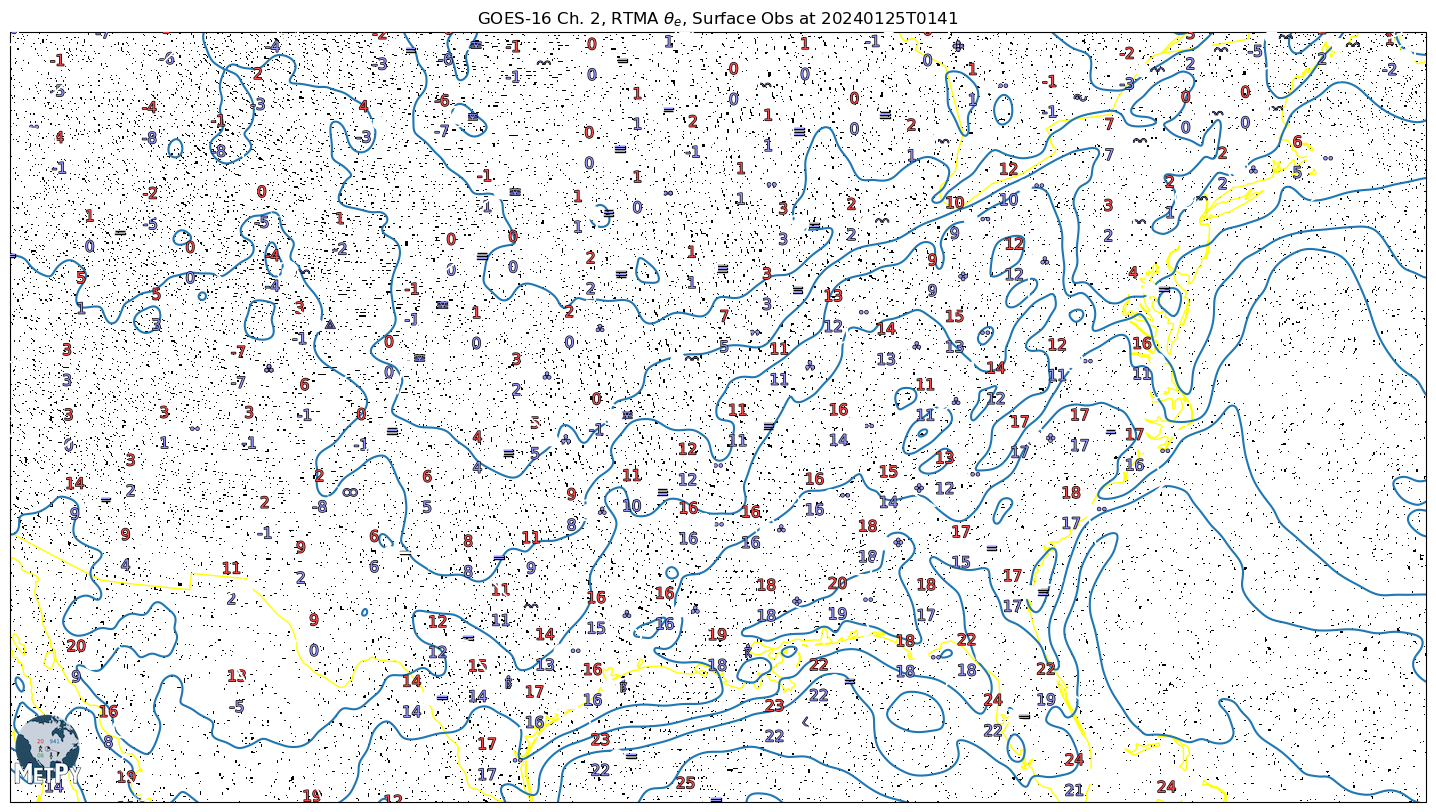

In [22]:
# Create axes
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection=rtma_crs)

# Plot satellite image:
# regrid_shape controls the detail of the reprojection 
# of the satellite data; a smaller number indicates 
# faster plotting at the expense of detail. 
# Start with 500 to get a general sense of the data, 
# and increase to ~6000 for better quality plots. 
image_extent = (cmi.metpy.x[0], cmi.metpy.x[-1], cmi.metpy.y[0], cmi.metpy.y[-1])
ax.imshow(cmi, extent=image_extent, origin='lower', cmap='Greys_r',
          regrid_shape=6000, transform=cmi.metpy.cartopy_crs)

# Plot theta_e as contours:
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e,
           levels=range(240, 400, 8), colors='tab:blue', 
           transform=theta_e.metpy.cartopy_crs)

# Plot surface observations as a station plot:
# Here we are also adding several readability modifications.
#     path_effects - used to draw the text with a thin 
#                    outline to help it show up better.
#     RGB colors   - used to lighten up the default red  
#                    and blue to make text stand out.
stn = mpplots.StationPlot(ax, sfc_data['longitude'][plot_mask].m, sfc_data['latitude'][plot_mask].m,
                          transform=ccrs.PlateCarree(), fontsize=11, zorder=10, clip_on=True)
stn.plot_parameter('NW', sfc_data['air_temperature'][plot_mask], color=[1.0,0.3,0.3],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][plot_mask], color=[0.6,0.6,1.0],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_symbol('C', sfc_data['cloud_coverage'][plot_mask], mpplots.sky_cover, color='white')
stn.plot_symbol('E', sfc_data['current_wx1_symbol'][plot_mask], mpplots.current_weather, color=[0.6,0.6,1.0],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_barb(sfc_data['eastward_wind'][plot_mask], sfc_data['northward_wind'][plot_mask], color='white')

# Finishing touches, including logo and title
ax.add_feature(cfeature.BORDERS, color='yellow')
ax.add_feature(cfeature.COASTLINE, color='yellow')
ax.set_extent((-113, -70, 25, 45))
ax.set_title(r'GOES-16 Ch. 2, RTMA $\theta_e$, Surface Obs at {:%Y%m%dT%H%M}'.format(dt))
mpplots.add_metpy_logo(fig)

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Activity: Make the plot your own</p>
    Use the remaining time to stylize your plot to you liking. Use the cell below to experiment with your plot.<br> 
Some ideas:
    <ul>
        <li>Stylize the title of the plot, changing the size</li>
        <li>Change the colors of the contours or station plots</li>
        <li>Add additional variables to the station plots</li>
        <li>Swap the theta_e contours with another RTMA variable</li>
    </ul>
Challenges: 
    <ul>
        <li>Make this a 3-panel plot with 3 separate axes</li>
        <li>Add labels to your theta_e contours</li>
        <li>Review the MetPy example gallery and add elements to your plot</li>
        <dl>
            <dd><a href="https://unidata.github.io/MetPy/latest/examples/index.html" target="blank">https://unidata.github.io/MetPy/latest/examples/index.html</a></dd>
        </dl>
    </ul>
Share your final plots with us in the room or mention <a href="https://twitter.com/Metpy" target="blank">@metpy on Twitter</a>
</div>


In [23]:
# ACTIVITY: Make the plot your own

